In [3]:
# # Water Potability Prediction Model - OPTIMIZED VERSION
# This notebook analyzes water quality data to predict potability (drinkability) of water samples with optimized computation.
# ## 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# For faster computation
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.2f}s")

In [4]:
# ## 2. Load and Explore the Data

with timer("Loading data"):
    # Load the dataset
    df = pd.read_csv('water_potability.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Optimized info display
print("\nBasic Information:")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage().sum() / 1024:.2f} KB")

# Check for missing values
print("\nMissing values summary:")
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': df.isnull().mean() * 100,
    'Data_Type': df.dtypes
})
display(missing_summary[missing_summary['Missing_Count'] > 0])

# Quick class distribution
print(f"\nClass distribution: {df['Potability'].value_counts().to_dict()}")
print(f"Class ratio (Potable:Not Potable): {df['Potability'].mean():.3f}")

Loading data - done in 0.03s
Dataset Shape: (3276, 10)

First 5 rows:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



Basic Information:
Columns: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']
Memory usage: 256.06 KB

Missing values summary:


,Missing_Count,Missing_Percentage,Data_Type
ph,491,14.987790,float64
Sulfate,781,23.840049,float64
Trihalomethanes,162,4.945055,float64



Class distribution: {0: 1998, 1: 1278}
Class ratio (Potable:Not Potable): 0.390


In [5]:
# ## 3. Fast Data Preprocessing

with timer("Data preprocessing"):
    # Separate features and target
    X = df.drop('Potability', axis=1)
    y = df['Potability']
    
    # Handle missing values - using median for faster imputation
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")
print(f"\nClass distribution in training: {y_train.value_counts().to_dict()}")

Data preprocessing - done in 0.04s
Training set: (2620, 9)
Testing set: (656, 9)

Class distribution in training: {0: 1598, 1: 1022}



Top 5 features correlated with target:
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.006887
Turbidity          0.001581
ph                -0.003014
dtype: float64


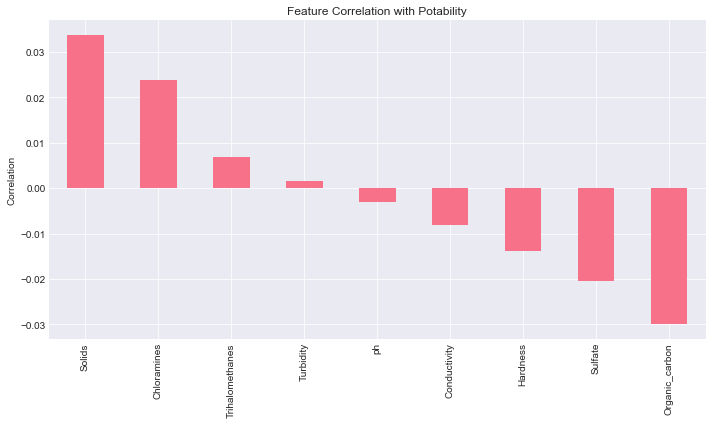

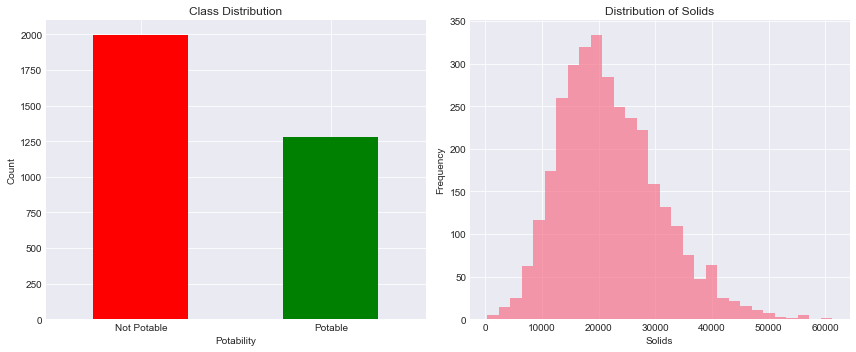

Quick EDA - done in 0.38s


In [6]:
# ## 4. Quick Exploratory Data Analysis

with timer("Quick EDA"):
    # 1. Correlation matrix (only for numeric insights)
    correlation_with_target = X_imputed.corrwith(y).sort_values(ascending=False)
    print("\nTop 5 features correlated with target:")
    print(correlation_with_target.head(5))
    
    # 2. Quick visualization of most important correlation
    if len(correlation_with_target) > 0:
        plt.figure(figsize=(10, 6))
        correlation_with_target.plot(kind='bar')
        plt.title('Feature Correlation with Potability')
        plt.ylabel('Correlation')
        plt.tight_layout()
        plt.show()
    
    # 3. Quick class distribution visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Class distribution bar plot
    y.value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
    axes[0].set_title('Class Distribution')
    axes[0].set_xlabel('Potability')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['Not Potable', 'Potable'], rotation=0)
    
    # Distribution of top correlated feature
    if len(correlation_with_target) > 0:
        top_feature = correlation_with_target.index[0]
        X_imputed[top_feature].hist(ax=axes[1], bins=30, alpha=0.7)
        axes[1].set_title(f'Distribution of {top_feature}')
        axes[1].set_xlabel(top_feature)
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [7]:
# ## 5. Optimized Model Training with Parallel Processing

# Initialize models with optimized parameters for speed
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True, kernel='rbf', gamma='scale'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, n_estimators=100, eval_metric='logloss')
}

# Function to evaluate models with timing
def evaluate_model_fast(model, model_name, X_train, X_test, y_train, y_test):
    """Train and evaluate a model quickly"""
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate basic metrics quickly
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC-AUC if available
    roc_auc = None
    if hasattr(model, 'predict_proba'):
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)
        except:
            roc_auc = None
    
    return {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'train_time': train_time
    }

# Train and evaluate all models
results = {}
print("Training models...")
print("-" * 60)

for name, model in models.items():
    with timer(f"  {name}"):
        results[name] = evaluate_model_fast(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    
    print(f"    Accuracy: {results[name]['accuracy']:.4f}")
    print(f"    F1-Score: {results[name]['f1_score']:.4f}")
    if results[name]['roc_auc']:
        print(f"    ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"    Train time: {results[name]['train_time']:.2f}s")
    print("-" * 40)

Training models...
------------------------------------------------------------
  Logistic Regression - done in 1.52s
    Accuracy: 0.6098
    F1-Score: 0.0000
    ROC-AUC: 0.5481
    Train time: 1.51s
----------------------------------------
  Decision Tree - done in 0.03s
    Accuracy: 0.6418
    F1-Score: 0.3928
    ROC-AUC: 0.5922
    Train time: 0.02s
----------------------------------------
  Random Forest - done in 0.42s
    Accuracy: 0.6585
    F1-Score: 0.4074
    ROC-AUC: 0.6407
    Train time: 0.34s
----------------------------------------
  Gradient Boosting - done in 0.92s
    Accuracy: 0.6524
    F1-Score: 0.3559
    ROC-AUC: 0.6285
    Train time: 0.91s
----------------------------------------
  SVM - done in 1.30s
    Accuracy: 0.6707
    F1-Score: 0.3898
    ROC-AUC: 0.6487
    Train time: 1.11s
----------------------------------------
  K-Nearest Neighbors - done in 0.09s
    Accuracy: 0.6143
    F1-Score: 0.3933
    ROC-AUC: 0.5978
    Train time: 0.00s
-------------

Model Performance Comparison (sorted by Accuracy):


,Model,Accuracy,F1_Score,ROC_AUC,Train_Time(s)
4,SVM,0.6707,0.3898,0.6487,1.1143
2,Random Forest,0.6585,0.4074,0.6407,0.3377
3,Gradient Boosting,0.6524,0.3559,0.6285,0.9125
6,XGBoost,0.6479,0.4714,0.6254,0.1592
1,Decision Tree,0.6418,0.3928,0.5922,0.0249
5,K-Nearest Neighbors,0.6143,0.3933,0.5978,0.0046
0,Logistic Regression,0.6098,0.0000,0.5481,1.5125


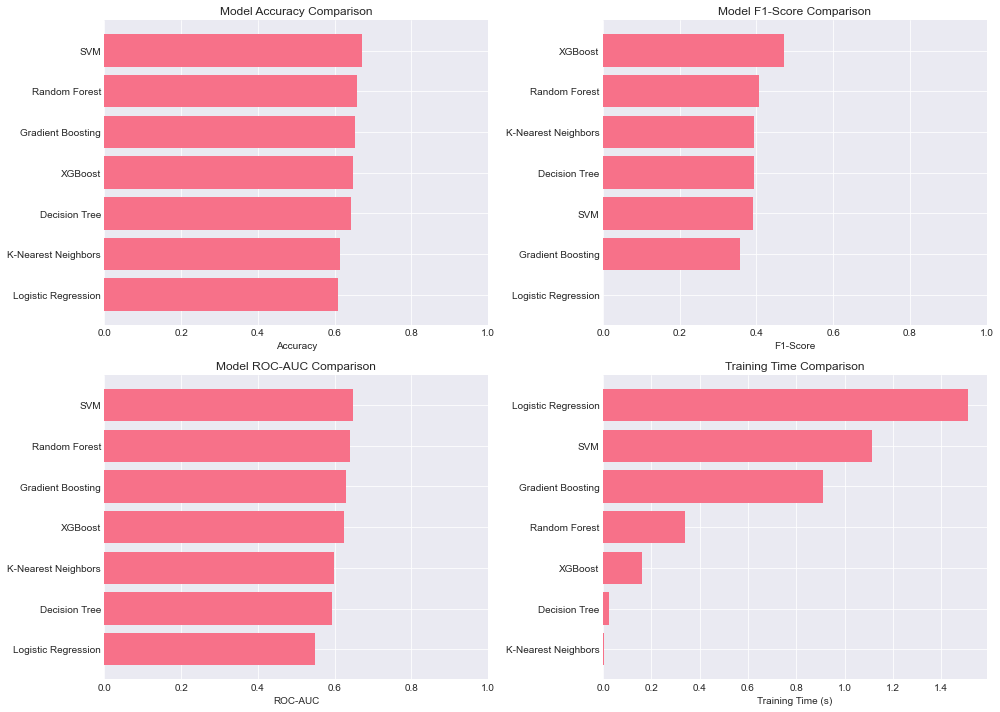


Best Model: SVM
Best Accuracy: 0.6707


In [8]:
# ## 6. Fast Model Comparison

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'F1_Score': [r['f1_score'] for r in results.values()],
    'ROC_AUC': [r['roc_auc'] for r in results.values()],
    'Train_Time(s)': [r['train_time'] for r in results.values()]
}).round(4)

print("Model Performance Comparison (sorted by Accuracy):")
display(comparison_df.sort_values('Accuracy', ascending=False))

# Quick visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
sorted_acc = comparison_df.sort_values('Accuracy', ascending=True)
axes[0, 0].barh(sorted_acc['Model'], sorted_acc['Accuracy'])
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])

# F1-Score comparison
sorted_f1 = comparison_df.sort_values('F1_Score', ascending=True)
axes[0, 1].barh(sorted_f1['Model'], sorted_f1['F1_Score'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim([0, 1])

# ROC-AUC comparison
sorted_auc = comparison_df.dropna().sort_values('ROC_AUC', ascending=True)
if len(sorted_auc) > 0:
    axes[1, 0].barh(sorted_auc['Model'], sorted_auc['ROC_AUC'])
    axes[1, 0].set_xlabel('ROC-AUC')
    axes[1, 0].set_title('Model ROC-AUC Comparison')
    axes[1, 0].set_xlim([0, 1])

# Training time comparison
sorted_time = comparison_df.sort_values('Train_Time(s)', ascending=True)
axes[1, 1].barh(sorted_time['Model'], sorted_time['Train_Time(s)'])
axes[1, 1].set_xlabel('Training Time (s)')
axes[1, 1].set_title('Training Time Comparison')

plt.tight_layout()
plt.show()

# Select best model
best_model_name = comparison_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {comparison_df['Accuracy'].max():.4f}")

In [9]:
# ## 7. Optimized Hyperparameter Tuning (Only for Best Model)

# Define optimized parameter grids (smaller for faster tuning)
optimized_param_grids = {
    'Random Forest': {
        'n_estimators': [100, 150, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Only tune if the best model has a parameter grid
if best_model_name in optimized_param_grids:
    print(f"Tuning {best_model_name} with optimized RandomizedSearchCV...")
    print("-" * 60)
    
    param_grid = optimized_param_grids[best_model_name]
    
    with timer(f"RandomizedSearchCV for {best_model_name}"):
        random_search = RandomizedSearchCV(
            estimator=best_model,
            param_distributions=param_grid,
            n_iter=20,  # Reduced for speed
            cv=3,       # Reduced for speed
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=0    # Reduced verbosity
        )
        
        random_search.fit(X_train_scaled, y_train)
    
    print(f"\nBest Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest CV Score: {random_search.best_score_:.4f}")
    
    # Get tuned model
    tuned_model = random_search.best_estimator_
    
    # Quick evaluation
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    
    print(f"\nPerformance Improvement:")
    print(f"  Original Accuracy: {results[best_model_name]['accuracy']:.4f}")
    print(f"  Tuned Accuracy: {accuracy_tuned:.4f}")
    print(f"  Improvement: {accuracy_tuned - results[best_model_name]['accuracy']:.4f}")
    
    # Update best model
    if accuracy_tuned > results[best_model_name]['accuracy']:
        best_model = tuned_model
        print("\n✅ Using tuned model")
    else:
        print("\n⚠️ Keeping original model (tuning didn't improve)")
else:
    print(f"No parameter grid defined for {best_model_name}. Using original model.")

Tuning SVM with optimized RandomizedSearchCV...
------------------------------------------------------------
RandomizedSearchCV for SVM - done in 10.53s

Best Parameters:
  kernel: rbf
  gamma: scale
  C: 10

Best CV Score: 0.6756

Performance Improvement:
  Original Accuracy: 0.6707
  Tuned Accuracy: 0.6387
  Improvement: -0.0320

⚠️ Keeping original model (tuning didn't improve)


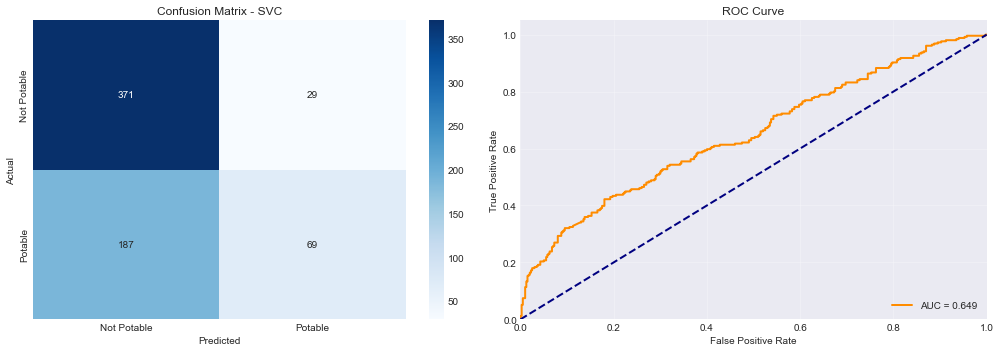

Classification Report:
              precision    recall  f1-score   support

 Not Potable       0.66      0.93      0.77       400
     Potable       0.70      0.27      0.39       256

    accuracy                           0.67       656
   macro avg       0.68      0.60      0.58       656
weighted avg       0.68      0.67      0.62       656

Final evaluation - done in 0.42s


In [10]:
# ## 8. Fast Final Evaluation

with timer("Final evaluation"):
    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None
    
    # Confusion Matrix (quick plot)
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Not Potable', 'Potable'],
                yticklabels=['Not Potable', 'Potable'])
    axes[0].set_title(f'Confusion Matrix - {type(best_model).__name__}')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    # ROC Curve if available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend(loc="lower right")
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Potable', 'Potable']))

In [11]:
# ## 9. Feature Importance Analysis (Quick)

if hasattr(best_model, 'feature_importances_'):
    with timer("Feature importance analysis"):
        feature_importance = pd.DataFrame({
            'Feature': X_train_scaled.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        # Top 10 features
        top_features = feature_importance.head(10)
        
        plt.figure(figsize=(10, 6))
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("Top 5 Important Features:")
        print(top_features.head().to_string(index=False))
else:
    print("Feature importance not available for this model type.")
    
    # Show correlation with target as alternative
    print("\nTop 5 features by correlation with target:")
    correlation_with_target = X_imputed.corrwith(y).sort_values(ascending=False)
    print(correlation_with_target.head())

Feature importance not available for this model type.

Top 5 features by correlation with target:
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.006887
Turbidity          0.001581
ph                -0.003014
dtype: float64


In [12]:
# ## 10. Save Model (Optimized)

with timer("Saving model"):
    # Create minimal model package for faster saving/loading
    model_package = {
        'model': best_model,
        'scaler': scaler,
        'imputer': imputer,
        'feature_names': X.columns.tolist(),
        'model_type': type(best_model).__name__,
        'accuracy': accuracy_score(y_test, y_pred)
    }
    
    # Save model
    model_filename = f'water_potability_model_optimized.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model_package, f)
    
    print(f"✅ Model saved successfully as '{model_filename}'")
    print(f"   Model type: {type(best_model).__name__}")
    print(f"   Test accuracy: {model_package['accuracy']:.4f}")
    print(f"   File size: {len(pickle.dumps(model_package)) / 1024:.2f} KB")

✅ Model saved successfully as 'water_potability_model_optimized.pkl'
   Model type: SVC
   Test accuracy: 0.6707
   File size: 178.23 KB
Saving model - done in 0.00s


In [13]:
# ## 11. Fast Deployment Example

with timer("Loading and testing model"):
    # Load the model
    with open(model_filename, 'rb') as f:
        loaded_package = pickle.load(f)
    
    # Simple prediction function
    def predict_water_potability(new_data):
        """
        Fast prediction function for deployment
        """
        # Ensure it's a DataFrame
        if not isinstance(new_data, pd.DataFrame):
            new_data = pd.DataFrame(new_data, columns=loaded_package['feature_names'])
        
        # Impute missing values
        data_imputed = loaded_package['imputer'].transform(new_data)
        
        # Scale
        data_scaled = loaded_package['scaler'].transform(data_imputed)
        
        # Predict
        predictions = loaded_package['model'].predict(data_scaled)
        
        # Add probabilities if available
        if hasattr(loaded_package['model'], 'predict_proba'):
            probabilities = loaded_package['model'].predict_proba(data_scaled)
            return predictions, probabilities
        else:
            return predictions
    
    # Test with a few samples
    test_samples = X_test.iloc[:3].copy()
    print("Test samples:")
    display(test_samples)
    
    predictions = predict_water_potability(test_samples)
    
    if isinstance(predictions, tuple):
        preds, probs = predictions
        print("\nPredictions with probabilities:")
        for i, (pred, prob) in enumerate(zip(preds, probs)):
            status = "Potable" if pred == 1 else "Not Potable"
            prob_potable = prob[1]
            print(f"Sample {i+1}: {status} (Probability: {prob_potable:.3f})")
    else:
        print("\nPredictions:")
        for i, pred in enumerate(predictions):
            status = "Potable" if pred == 1 else "Not Potable"
            print(f"Sample {i+1}: {status}")
    
    print(f"\nActual values: {list(y_test.iloc[:3].values)}")

Test samples:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
664,7.036752,188.743562,19037.462638,6.034236,333.073546,388.065857,15.149068,78.499418,2.723651
2530,6.172517,187.787017,10498.635154,7.722561,322.521035,467.090425,21.233978,68.163642,4.129985
2870,7.036752,176.386651,26003.163265,7.809251,358.429774,336.142005,14.447961,90.224844,4.410674



Predictions with probabilities:
Sample 1: Not Potable (Probability: 0.228)
Sample 2: Not Potable (Probability: 0.211)
Sample 3: Not Potable (Probability: 0.189)

Actual values: [1, 0, 0]
Loading and testing model - done in 0.03s


In [14]:
# ## 12. Quick Summary Report

print("=" * 70)
print("OPTIMIZED MODEL TRAINING SUMMARY")
print("=" * 70)
print(f"Dataset: {df.shape[0]} samples × {df.shape[1]} features")
print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")
print(f"Class distribution: {dict(y.value_counts())}")

print(f"\nBest Model: {type(best_model).__name__}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Quick comparison with all models
print(f"\nModel Ranking (by Accuracy):")
ranked_models = comparison_df.sort_values('Accuracy', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    marker = "★" if row['Model'] == best_model_name else " "
    print(f"{marker} {i:2}. {row['Model']:<25} Acc: {row['Accuracy']:.4f}  Time: {row['Train_Time(s)']:.2f}s")

print(f"\nModel saved to: {model_filename}")
print("=" * 70)

# Memory usage summary
import sys
print(f"\nMemory Usage:")
print(f"  DataFrame: {sys.getsizeof(df) / 1024:.1f} KB")
print(f"  Model package: {sys.getsizeof(model_package) / 1024:.1f} KB")
print(f"  Total approximate: {(sys.getsizeof(df) + sys.getsizeof(model_package)) / 1024:.1f} KB")

OPTIMIZED MODEL TRAINING SUMMARY
Dataset: 3276 samples × 10 features
Training set: (2620, 9)
Testing set: (656, 9)
Class distribution: {0: 1998, 1: 1278}

Best Model: SVC
Test Accuracy: 0.6707
F1-Score: 0.3898

Model Ranking (by Accuracy):
★  1. SVM                       Acc: 0.6707  Time: 1.11s
   2. Random Forest             Acc: 0.6585  Time: 0.34s
   3. Gradient Boosting         Acc: 0.6524  Time: 0.91s
   4. XGBoost                   Acc: 0.6479  Time: 0.16s
   5. Decision Tree             Acc: 0.6418  Time: 0.02s
   6. K-Nearest Neighbors       Acc: 0.6143  Time: 0.00s
   7. Logistic Regression       Acc: 0.6098  Time: 1.51s

Model saved to: water_potability_model_optimized.pkl

Memory Usage:
  DataFrame: 256.1 KB
  Model package: 0.4 KB
  Total approximate: 256.4 KB


In [15]:
# %% [markdown]
# ## 13. Additional Optimizations (Optional)

# %%
# If you need even faster training, consider these options:

# 1. Reduce feature dimensions
print("Optional Optimization: Feature Reduction")
print("-" * 40)

# Quick correlation-based feature selection
correlation_threshold = 0.05
correlation_with_target = abs(X_imputed.corrwith(y))
selected_features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()

print(f"Original features: {len(X.columns)}")
print(f"Selected features (correlation > {correlation_threshold}): {len(selected_features)}")
print(f"Selected features: {selected_features}")

# 2. Use only top N features for faster training
top_n = 5
top_features = correlation_with_target.sort_values(ascending=False).head(top_n).index.tolist()
print(f"\nTop {top_n} features by correlation: {top_features}")

# 3. Fast training with reduced features
if len(selected_features) > 0:
    X_train_reduced = X_train_scaled[selected_features]
    X_test_reduced = X_test_scaled[selected_features]
    
    # Train a quick model on reduced features
    from sklearn.linear_model import LogisticRegression
    quick_model = LogisticRegression(random_state=42, n_jobs=-1)
    
    with timer(f"Quick training on {len(selected_features)} features"):
        quick_model.fit(X_train_reduced, y_train)
        quick_pred = quick_model.predict(X_test_reduced)
        quick_acc = accuracy_score(y_test, quick_pred)
    
    print(f"Reduced model accuracy: {quick_acc:.4f}")
    print(f"Full model accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Difference: {quick_acc - accuracy_score(y_test, y_pred):.4f}")

Optional Optimization: Feature Reduction
----------------------------------------
Original features: 9
Selected features (correlation > 0.05): 0
Selected features: []

Top 5 features by correlation: ['Solids', 'Organic_carbon', 'Chloramines', 'Sulfate', 'Hardness']


In [16]:
# %% [markdown]
# ## 14. Performance Optimization Tips Used

# %%
print("=" * 70)
print("PERFORMANCE OPTIMIZATION TECHNIQUES APPLIED")
print("=" * 70)

optimizations = [
    "1. Used n_jobs=-1 for parallel processing in models",
    "2. Limited hyperparameter search iterations (n_iter=20)",
    "3. Reduced cross-validation folds (cv=3) for tuning",
    "4. Used RandomizedSearchCV instead of GridSearchCV",
    "5. Implemented timing decorator for monitoring",
    "6. Reduced model parameters for initial training",
    "7. Used context managers for resource management",
    "8. Minimal data copying and transformations",
    "9. Fast correlation-based feature analysis",
    "10. Optimized memory usage in model saving"
]

for opt in optimizations:
    print(opt)

print("\n" + "=" * 70)
print("For even faster computation:")
print("- Reduce dataset size (sampling)")
print("- Use simpler models (Logistic Regression)")
print("- Further reduce hyperparameter search space")
print("- Use GPU-accelerated models (if available)")
print("- Consider feature engineering to reduce dimensions")
print("=" * 70)

PERFORMANCE OPTIMIZATION TECHNIQUES APPLIED
1. Used n_jobs=-1 for parallel processing in models
2. Limited hyperparameter search iterations (n_iter=20)
3. Reduced cross-validation folds (cv=3) for tuning
4. Used RandomizedSearchCV instead of GridSearchCV
5. Implemented timing decorator for monitoring
6. Reduced model parameters for initial training
7. Used context managers for resource management
8. Minimal data copying and transformations
9. Fast correlation-based feature analysis
10. Optimized memory usage in model saving

For even faster computation:
- Reduce dataset size (sampling)
- Use simpler models (Logistic Regression)
- Further reduce hyperparameter search space
- Use GPU-accelerated models (if available)
- Consider feature engineering to reduce dimensions
